# 零温弹性常数计算

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bud-primordium/ThermoElasticSim/blob/main/docs/source/tutorial/02_zero_temperature.ipynb)

在上一章中，我们学习了体系建模与应力计算的基本方法。本章将聚焦材料力学性质的核心——零温弹性常数（C11、C12、C44）的计算。

## 学习目标

通过本章，你将能够：
- 理解显式形变法（explicit deformation method）的物理原理
- 手工复刻应变→内部弛豫→应力→线性拟合的完整流程
- 计算立方晶系的三个独立弹性常数（C11、C12、C44）
- 分析有限尺寸效应对计算精度的影响
- 使用高级 API 与 YAML 配置完成批量与一键计算

## 物理背景

零温条件下，晶体的弹性响应遵循广义胡克定律：
$$\sigma_{ij} = C_{ijkl} \varepsilon_{kl}$$

对立方晶系，弹性张量具有高度对称性，仅有三个独立分量：
- **C11**：单轴拉伸/压缩的纵向模量
- **C12**：横向耦合（泊松效应）
- **C44**：剪切模量

本章采用显式形变法：对基态施加微小应变，执行内部弛豫，测量应力，利用应力–应变的线性关系拟合得到弹性常数。

## 准备与导入

本章直接计算（零温较快），不依赖缓存或历史日志。

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import Image, display

# 核心模块导入
from thermoelasticsim.core import CrystallineStructureBuilder
from thermoelasticsim.elastic.benchmark import (
    BenchmarkConfig,
    run_size_sweep,
    run_zero_temp_benchmark,
)
from thermoelasticsim.elastic.deformation_method.zero_temp import (
    ShearDeformationMethod,
)
from thermoelasticsim.elastic.materials import ALUMINUM_FCC, CARBON_DIAMOND
from thermoelasticsim.potentials.eam import EAMAl1Potential
from thermoelasticsim.potentials.tersoff import TersoffC1988Potential
from thermoelasticsim.utils.plot_config import plt
from thermoelasticsim.utils.utils import EV_TO_GPA
from thermoelasticsim.visualization.api import (
    plot_c11_c12_combined_response,
    plot_shear_response,
)

# 设置随机种子确保结果可重现
np.random.seed(42)
DEFAULT_SIZE = (4, 4, 4)  # 默认超胞尺寸，与YAML配置一致


def fit_slope_r2(x: np.ndarray, y: np.ndarray):
    """线性拟合并返回斜率和R²值"""
    coeffs = np.polyfit(x, y, 1)  # 一次多项式拟合
    y_pred = np.polyval(coeffs, x)  # 预测值
    ss_res = np.sum((y - y_pred) ** 2)  # 残差平方和
    ss_tot = np.sum((y - np.mean(y)) ** 2)  # 总平方和
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else 1.0
    return float(coeffs[0]), float(r2)

INFO: 字体配置成功，优先使用: Arial Unicode MS


## 构建结构与基态制备

在立方晶系中，通常使用等比例晶格弛豫（uniform_lattice_relax）即可高效制备无应力基态；若不收敛再回退到完全弛豫（full_relax）。

In [2]:
# 构建FCC铝超胞结构
builder = CrystallineStructureBuilder()
mat = ALUMINUM_FCC
cell = builder.create_fcc(mat.symbol, mat.lattice_constant, DEFAULT_SIZE)
potential = EAMAl1Potential()

# 使用基准配置创建弛豫器
cfg = BenchmarkConfig(supercell_size=DEFAULT_SIZE)
relaxer = cfg.build_relaxer()

# 基态制备：先尝试等比例晶格弛豫，失败则完全弛豫
ok = relaxer.uniform_lattice_relax(cell, potential)
if not ok:
    ok = relaxer.full_relax(cell, potential)

# 验证基态应力（应接近零）
base_stress = cell.calculate_stress_tensor(potential) * EV_TO_GPA
print("基态应力(GPa):")
print(np.array_str(base_stress, precision=6))
base_cell = cell  # 保存基态供后续使用

基态应力(GPa):
[[ 6.863336e-07 -1.781624e-15 -1.808479e-15]
 [-1.780575e-15  6.863336e-07 -1.812202e-15]
 [-1.800082e-15 -1.824798e-15  6.863336e-07]]


## 手动计算 C11/C12（单轴应变法）

当施加单轴应变 εxx 时：
- **纵向应力响应**：σxx ≈ C11·εxx
- **横向应力响应**：σyy = σzz ≈ C12·εxx（泊松效应）

计算步骤：
1. 施加一系列小应变（-0.3% 到 +0.3%）
2. 对每个应变态进行内部弛豫
3. 测量应力张量分量
4. 线性拟合提取弹性常数

C11=110.24 GPa (文献110.0, 误差 0.22%), R²=0.999
C12=61.39 GPa (文献61.0, 误差 0.64%), R²=1.000


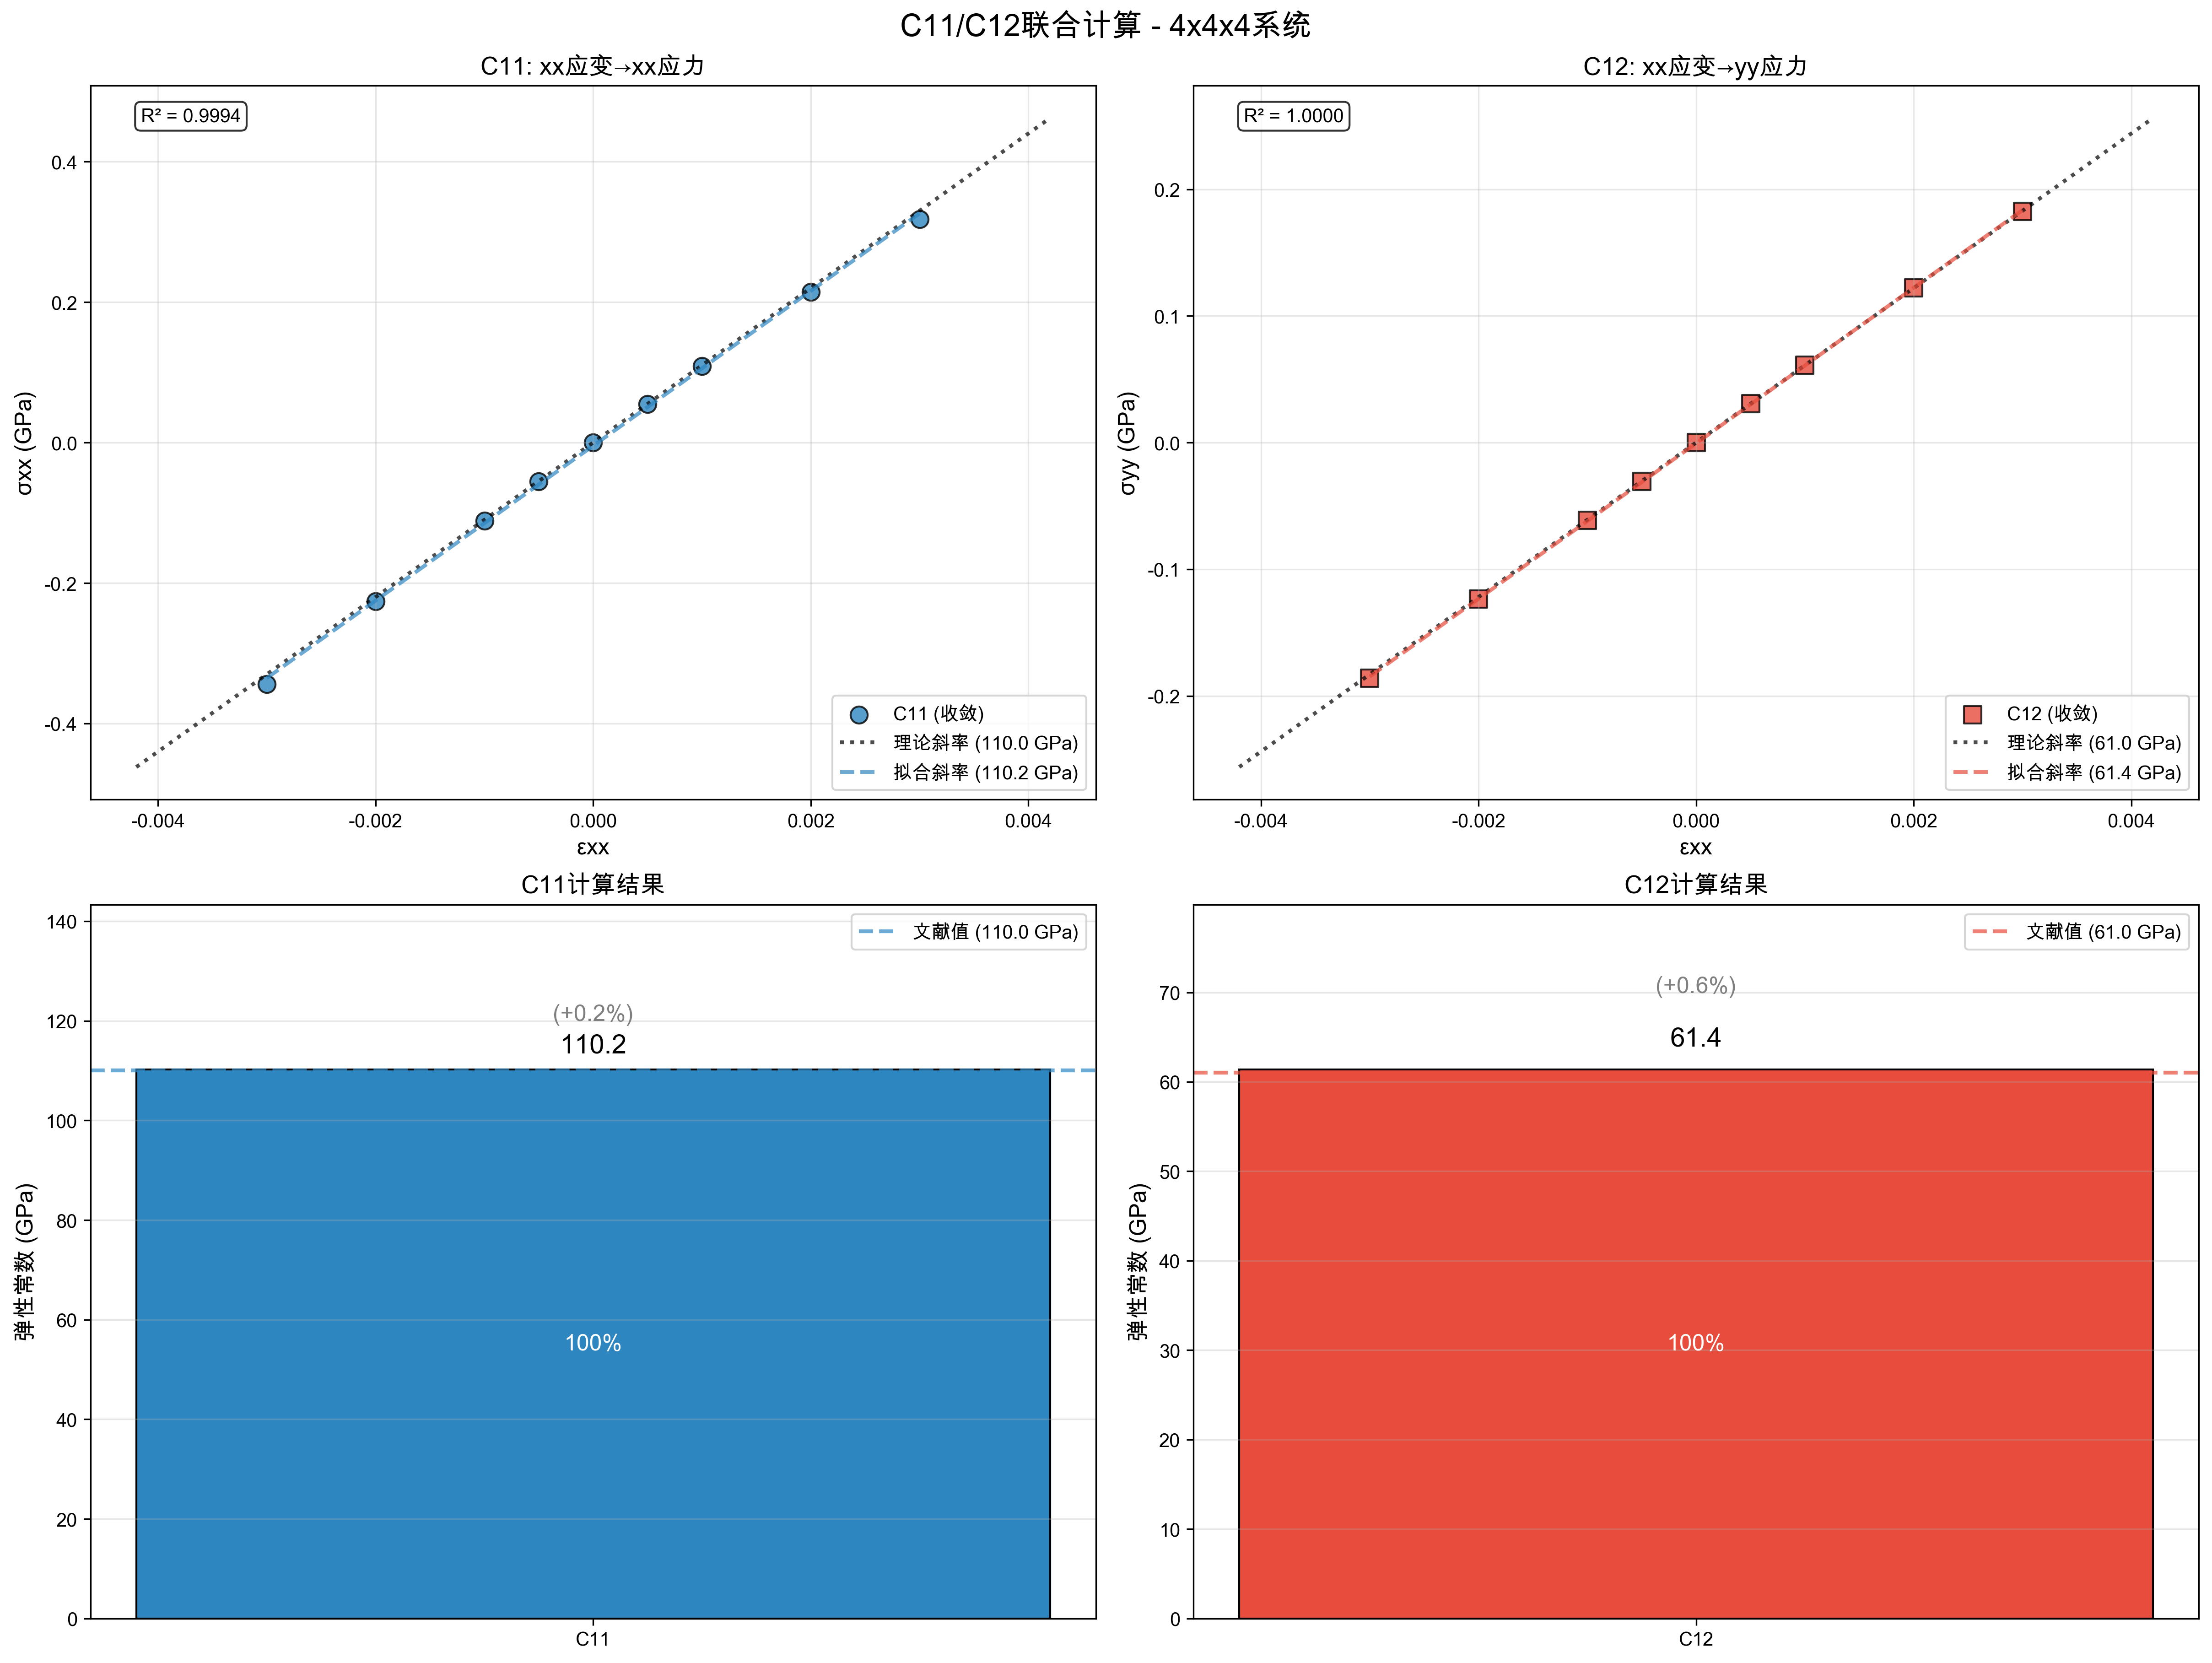

In [3]:
# 定义应变序列（从压缩到拉伸，含零点）
strains = np.array([-3e-3, -2e-3, -1e-3, -5e-4, 0.0, 5e-4, 1e-3, 2e-3, 3e-3])
c11_rows, c12_rows = [], []

# 对每个应变计算应力响应
for e in strains:
    if abs(e) < 1e-15:
        # 零应变直接使用基态
        stress = base_cell.calculate_stress_tensor(potential) * EV_TO_GPA
        converged = True
    else:
        # 构造形变梯度张量F
        F = np.eye(3)
        F[0, 0] += e  # 施加x方向单轴应变

        # 复制基态并施加形变
        c = base_cell.copy()
        c.apply_deformation(F)

        # 内部弛豫（仅优化原子位置）
        converged = relaxer.internal_relax(c, potential)
        stress = c.calculate_stress_tensor(potential) * EV_TO_GPA

    # 记录C11数据：σxx vs εxx
    c11_rows.append(
        {
            "applied_strain": float(e),
            "measured_stress_GPa": float(stress[0, 0]),
            "optimization_converged": bool(converged),
        }
    )
    # 记录C12数据：σyy vs εxx
    c12_rows.append(
        {
            "applied_strain": float(e),
            "measured_stress_GPa": float(stress[1, 1]),
            "optimization_converged": bool(converged),
        }
    )


def _fit(rows):
    """从应力-应变数据拟合弹性常数"""
    arr = [
        (r["applied_strain"], r["measured_stress_GPa"])
        for r in rows
        if r["optimization_converged"]
    ]
    if len(arr) < 2:
        return 0.0, 0.0
    x = np.array([a for a, _ in arr])
    y = np.array([b for _, b in arr])
    return fit_slope_r2(x, y)


# 拟合得到弹性常数
C11, r2_c11 = _fit(c11_rows)
C12, r2_c12 = _fit(c12_rows)

# 与文献值比较
lit = ALUMINUM_FCC.literature_elastic_constants
print(
    f"C11={C11:.2f} GPa (文献{lit['C11']:.1f}, 误差 {(abs(C11 - lit['C11']) / lit['C11'] * 100):.2f}%), R²={r2_c11:.3f}"
)
print(
    f"C12={C12:.2f} GPa (文献{lit['C12']:.1f}, 误差 {(abs(C12 - lit['C12']) / lit['C12'] * 100):.2f}%), R²={r2_c12:.3f}"
)

# 生成可视化图表
nx, ny, nz = DEFAULT_SIZE
out_path = Path("c11_c12_response_al.png")
plot_c11_c12_combined_response(c11_rows, c12_rows, (nx, ny, nz), str(out_path))
display(Image(filename=str(out_path)))

## 计算 C44（剪切应变法）

C44 描述晶体对剪切形变的抵抗能力。

关键特点：
- 采用标准剪切形变方法（数值稳定、实践成熟）
- 分别计算 yz/xz/xy 三个剪切面的响应
- 三个值应该相近（立方晶系的对称性检验）

C44=32.57 GPa (文献33.0, 误差 1.29%), R²(avg)=1.000


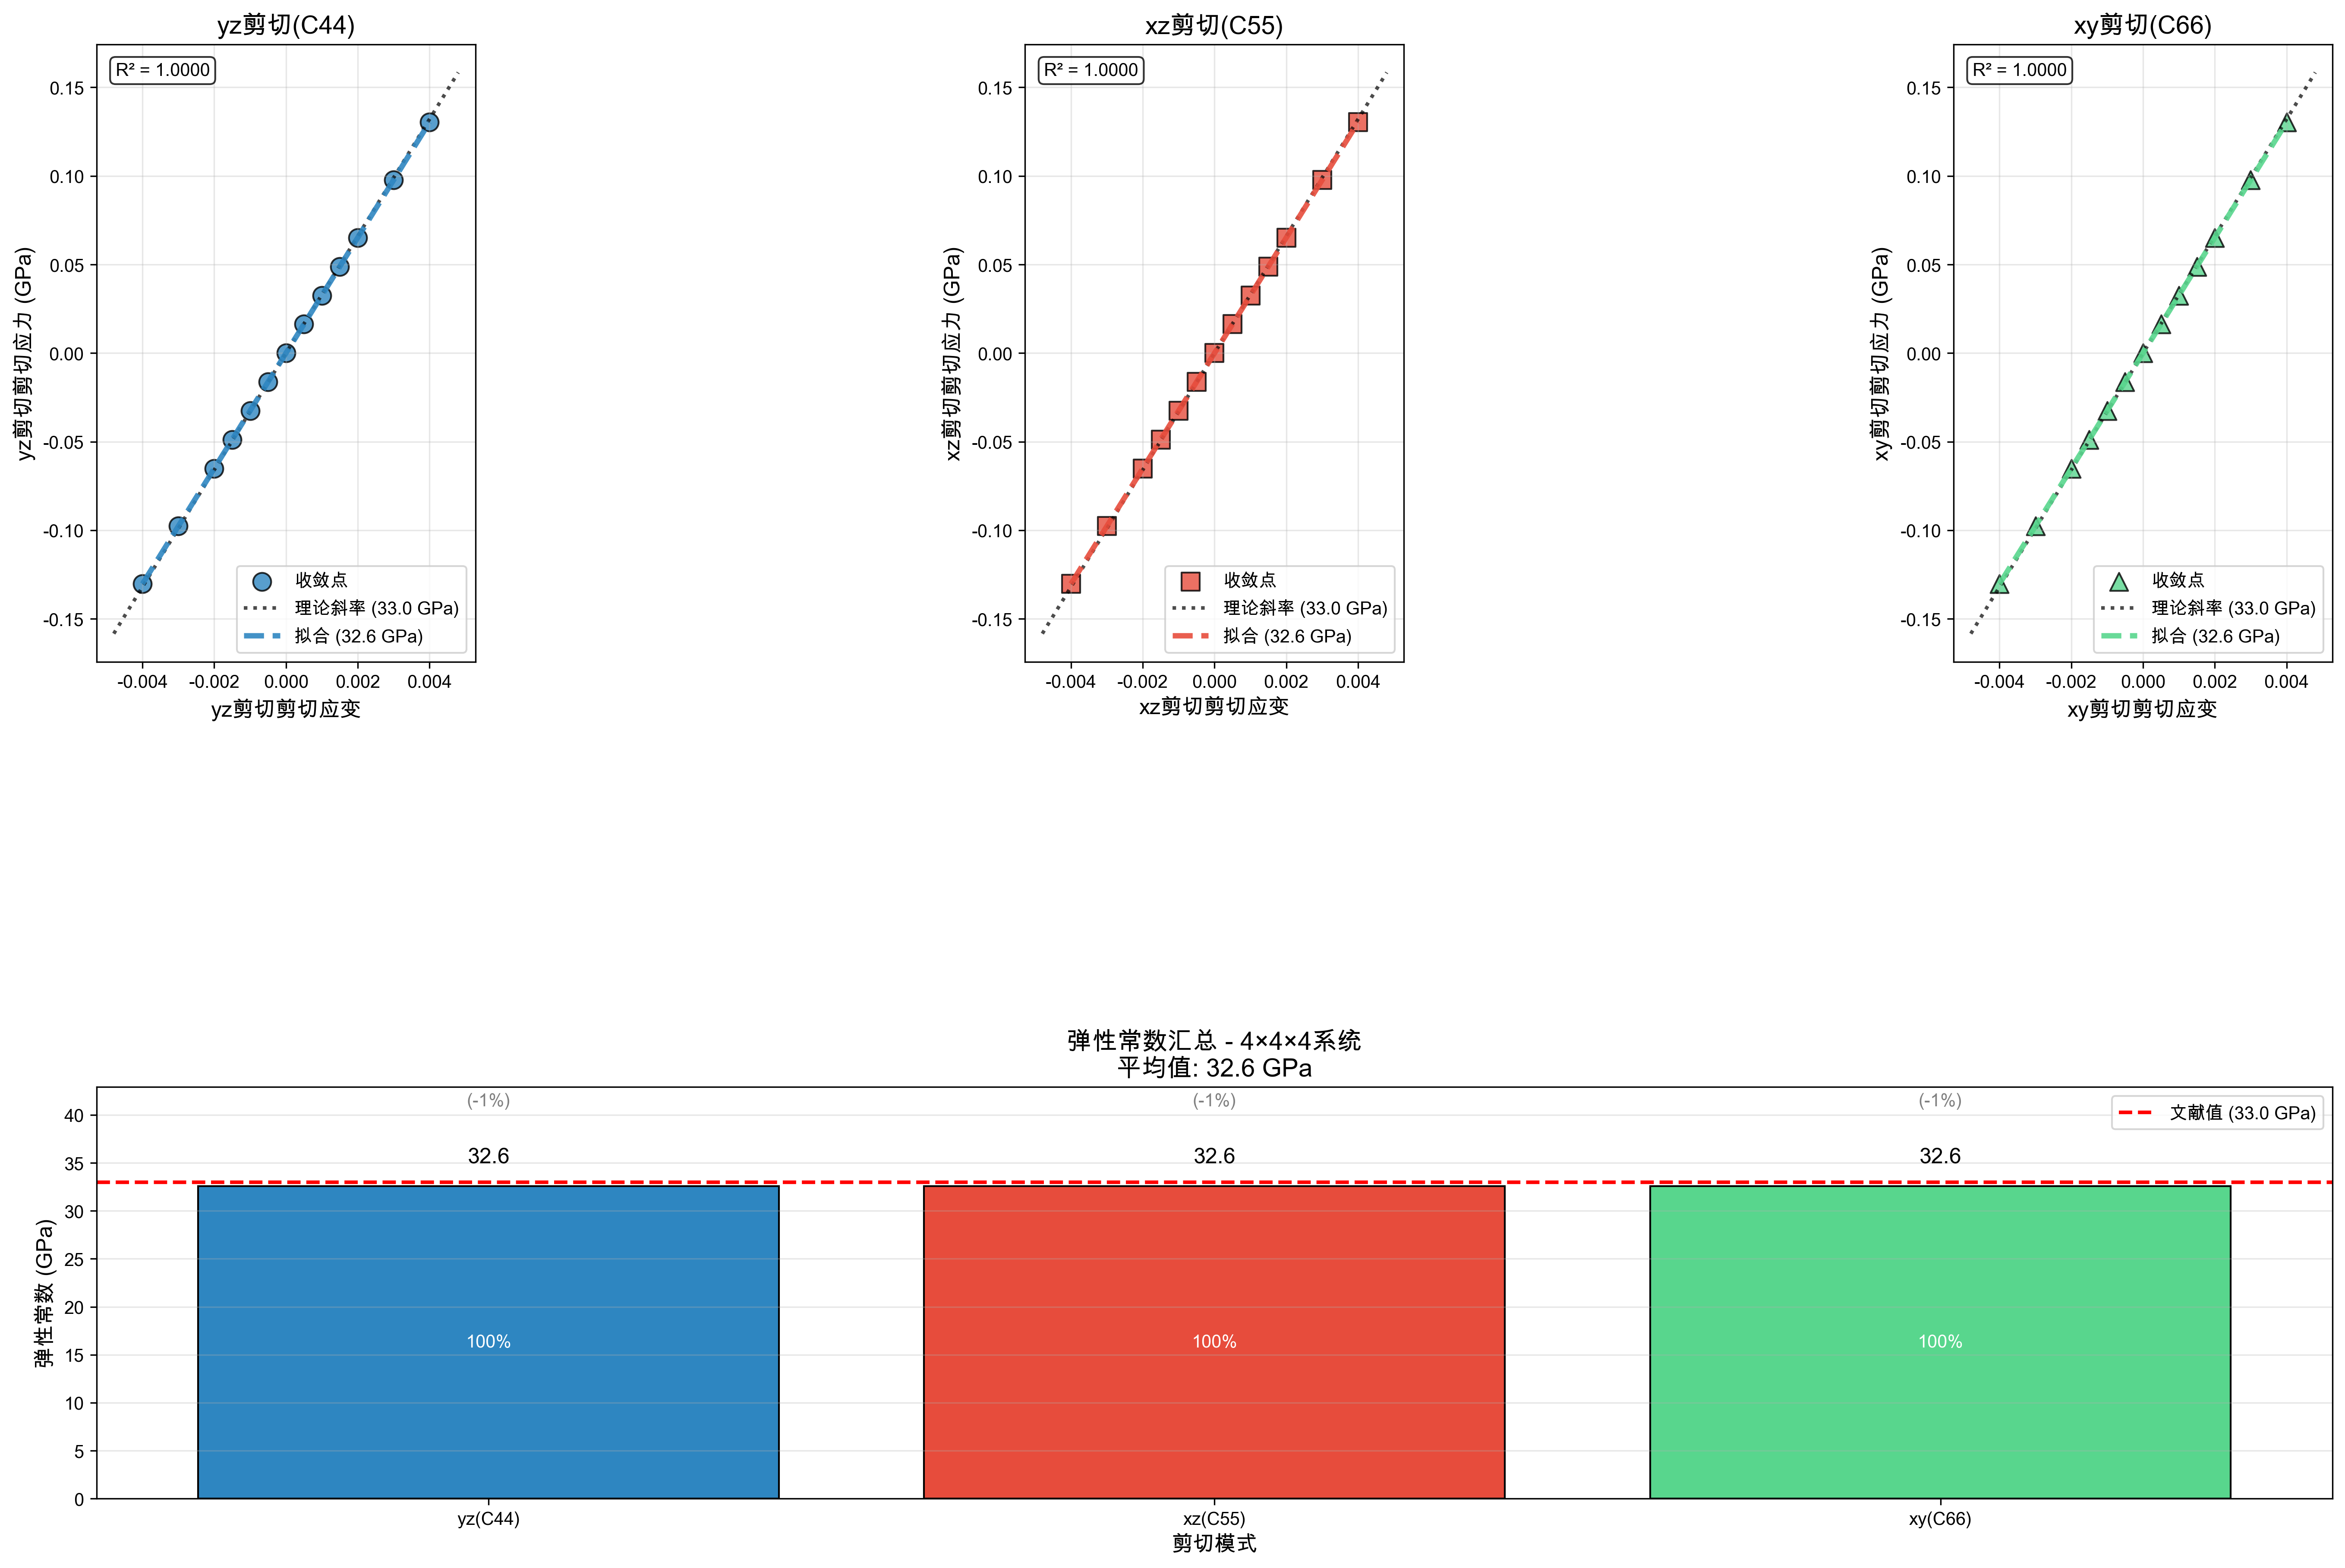

In [4]:
# 使用ShearDeformationMethod计算C44
shear_method = ShearDeformationMethod()
shear_strains = np.array(BenchmarkConfig().shear_strains)  # 默认剪切应变序列

# 计算三个独立剪切面的响应
c44_result = shear_method.calculate_c44_response(
    base_cell, potential, shear_strains, relaxer
)

# 提取汇总结果
summary = c44_result["summary"]
C44 = float(summary["C44"])
lit = ALUMINUM_FCC.literature_elastic_constants

# 输出结果与文献比较
print(
    f"C44={C44:.2f} GPa (文献{lit['C44']:.1f}, 误差 {(abs(C44 - lit['C44']) / lit['C44'] * 100):.2f}%), R²(avg)={summary['average_r2_score']:.3f}"
)

# 生成剪切响应可视化
nx, ny, nz = DEFAULT_SIZE
shear_png = Path("c44_shear_response_al.png")
plot_shear_response(c44_result["detailed_results"], (nx, ny, nz), str(shear_png))
display(Image(filename=str(shear_png)))

## 弹性模量汇总

由 Cij 可推得工程常用模量：体积模量 K、剪切模量 G、杨氏模量 E、泊松比 ν。

In [5]:
# 从三个独立弹性常数推导工程模量
K = (C11 + 2 * C12) / 3  # 体积模量
G = C44  # 剪切模量
E = 9 * K * G / (3 * K + G)  # 杨氏模量
nu = (3 * K - 2 * G) / (6 * K + 2 * G)  # 泊松比

print(f"体积模量 K={K:.2f} GPa")
print(f"剪切模量 G={G:.2f} GPa")
print(f"杨氏模量 E={E:.2f} GPa")
print(f"泊松比 ν={nu:.3f}")

体积模量 K=77.67 GPa
剪切模量 G=32.57 GPa
杨氏模量 E=85.74 GPa
泊松比 ν=0.316


## 有限尺寸效应分析

有限超胞会带来截断与边界效应。下面直接扫描三种尺寸，观察 Cij 收敛行为（零温计算较快，无需读取旧日志）。

In [6]:
# 扫描三个尺寸，观察收敛性
sizes = [(2, 2, 2), (3, 3, 3), (4, 4, 4)]
results = run_size_sweep(
    sizes=sizes,
    output_root=None,  # 不保存到文件
    material_params=ALUMINUM_FCC,
    potential_factory=EAMAl1Potential,
    precision=False,  # 快速模式
)

# 整理结果为DataFrame
rows = []
for r in results:
    nx, ny, nz = r["supercell_size"]
    ecs = r["elastic_constants"]
    rows.append(
        {
            "size": f"{nx}x{ny}x{nz}",
            "C11_GPa": ecs["C11"],
            "C12_GPa": ecs["C12"],
            "C44_GPa": ecs["C44"],
        }
    )
df_sizes = pd.DataFrame(rows)
display(df_sizes)

INFO:thermoelasticsim.elastic.benchmark:开始Al弹性常数基准：超胞=(2, 2, 2)（原子数=32）
INFO:thermoelasticsim.elastic.benchmark:制备无应力基态（优先等比例晶格弛豫）...
INFO:thermoelasticsim.elastic.deformation_method.zero_temp:开始等比例晶格弛豫：只优化晶格常数
INFO:thermoelasticsim.elastic.deformation_method.zero_temp:等比例晶格弛豫成功
INFO:thermoelasticsim.elastic.benchmark:基态应力(GPa): [0.000001, -0.295312, -0.295312; -0.295312, 0.000001, -0.295312; -0.295312, -0.295312, 0.000001]
INFO:thermoelasticsim.elastic.benchmark:单轴应变 εxx=-3.000000e-03 → σxx=-0.382633 GPa, σyy=-0.271162 GPa（收敛=True）
INFO:thermoelasticsim.elastic.benchmark:单轴应变 εxx=-2.000000e-03 → σxx=-0.274206 GPa, σyy=-0.200081 GPa（收敛=True）
INFO:thermoelasticsim.elastic.benchmark:单轴应变 εxx=-1.000000e-03 → σxx=-0.166283 GPa, σyy=-0.129314 GPa（收敛=True）
INFO:thermoelasticsim.elastic.benchmark:单轴应变 εxx=-5.000000e-04 → σxx=-0.112499 GPa, σyy=-0.094022 GPa（收敛=True）
INFO:thermoelasticsim.elastic.benchmark:单轴应变 εxx=0.000000e+00 → σxx=0.000001 GPa, σyy=0.000001 GPa（收敛=True）
INFO:thermoelasticsi

,size,C11_GPa,C12_GPa,C44_GPa
0,2x2x2,107.162339,70.242420,40.084864
1,3x3x3,97.427869,60.030439,30.527234
2,4x4x4,110.239151,61.387452,32.574605


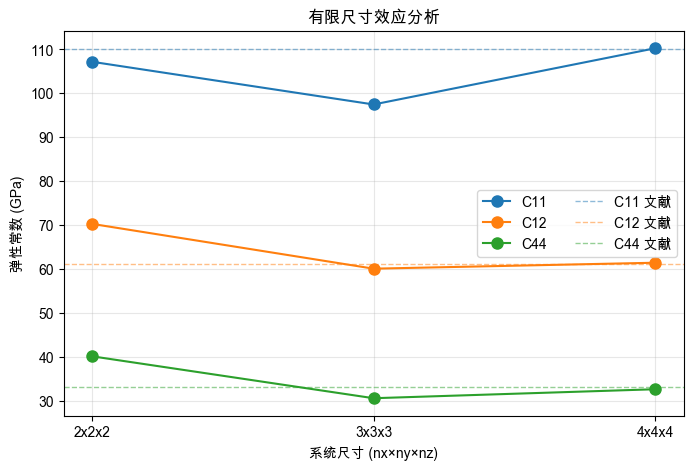

In [7]:
# 绘制收敛曲线
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(df_sizes["size"], df_sizes["C11_GPa"], "-o", label="C11", markersize=8)
ax.plot(df_sizes["size"], df_sizes["C12_GPa"], "-o", label="C12", markersize=8)
ax.plot(df_sizes["size"], df_sizes["C44_GPa"], "-o", label="C44", markersize=8)

# 添加文献参考线
lit = ALUMINUM_FCC.literature_elastic_constants
ax.axhline(lit["C11"], color="C0", ls="--", lw=1, alpha=0.5, label="C11 文献")
ax.axhline(lit["C12"], color="C1", ls="--", lw=1, alpha=0.5, label="C12 文献")
ax.axhline(lit["C44"], color="C2", ls="--", lw=1, alpha=0.5, label="C44 文献")

ax.set_xlabel("系统尺寸 (nx×ny×nz)")
ax.set_ylabel("弹性常数 (GPa)")
ax.set_title("有限尺寸效应分析")
ax.legend(ncol=2, loc="best")
ax.grid(True, alpha=0.3)
plt.show()

## 一键 API / YAML（高级用法）

理解原理后，可使用高级接口快速计算：

- **一键 API**：`run_zero_temp_benchmark(...)` - 内部完成全部流程
- **YAML配置**：`thermoelasticsim-run examples/modern_yaml/zero_temp_elastic.yaml`
- **批量扫描**：支持多尺寸、多材料的参数化计算

In [8]:
# 演示一键API的使用
res = run_zero_temp_benchmark(
    material_params=ALUMINUM_FCC,
    potential=EAMAl1Potential(),
    supercell_size=DEFAULT_SIZE,
    output_dir=None,  # 设置路径可保存结果
    save_json=False,  # 是否保存JSON格式数据
    precision=False,  # 快速模式
)

# 提取结果
ecs = res["elastic_constants"]
errs = res["errors"]

# 格式化输出
print("一键API结果：")
print(f"  C11={ecs['C11']:.2f} GPa")
print(f"  C12={ecs['C12']:.2f} GPa")
print(f"  C44={ecs['C44']:.2f} GPa")
print(f"  平均误差={errs['average_error_percent']:.2f}%")

INFO:thermoelasticsim.elastic.benchmark:开始Al弹性常数基准：超胞=(4, 4, 4)（原子数=256）
INFO:thermoelasticsim.elastic.benchmark:制备无应力基态（优先等比例晶格弛豫）...
INFO:thermoelasticsim.elastic.deformation_method.zero_temp:开始等比例晶格弛豫：只优化晶格常数
INFO:thermoelasticsim.elastic.deformation_method.zero_temp:等比例晶格弛豫成功
INFO:thermoelasticsim.elastic.benchmark:基态应力(GPa): [0.000001, -0.000000, -0.000000; -0.000000, 0.000001, -0.000000; -0.000000, -0.000000, 0.000001]
INFO:thermoelasticsim.elastic.benchmark:单轴应变 εxx=-3.000000e-03 → σxx=-0.343715 GPa, σyy=-0.185925 GPa（收敛=True）
INFO:thermoelasticsim.elastic.benchmark:单轴应变 εxx=-2.000000e-03 → σxx=-0.226191 GPa, σyy=-0.123534 GPa（收敛=True）
INFO:thermoelasticsim.elastic.benchmark:单轴应变 εxx=-1.000000e-03 → σxx=-0.111631 GPa, σyy=-0.061564 GPa（收敛=True）
INFO:thermoelasticsim.elastic.benchmark:单轴应变 εxx=-5.000000e-04 → σxx=-0.055452 GPa, σyy=-0.030732 GPa（收敛=True）
INFO:thermoelasticsim.elastic.benchmark:单轴应变 εxx=0.000000e+00 → σxx=0.000001 GPa, σyy=0.000001 GPa（收敛=True）
INFO:thermoelastics

一键API结果：
  C11=110.24 GPa
  C12=61.39 GPa
  C44=32.57 GPa
  平均误差=0.71%


## Diamond（单尺寸，Tersoff 1988）

共价材料（如金刚石）适合使用 Tersoff 势。短程势下 (2×2×2) 超胞即可得到稳定结果。

In [9]:
# 计算金刚石碳的弹性常数（Tersoff势）
res_dia = run_zero_temp_benchmark(
    material_params=CARBON_DIAMOND,
    potential=TersoffC1988Potential(),
    supercell_size=(2, 2, 2),  # 短程势，小尺寸即可
    output_dir=None,
    save_json=False,
    precision=False,
)

# 提取结果
ecs = res_dia["elastic_constants"]
errs = res_dia["errors"]
lit = CARBON_DIAMOND.literature_elastic_constants

# 格式化输出
print("金刚石弹性常数（2×2×2超胞）:")
print("=" * 40)
print(f"C11 = {ecs['C11']:.1f} GPa")
print(f"      文献值: {lit['C11']:.1f} GPa")
print(f"      误差: {errs['C11_error_percent']:.2f}%")
print(f"\nC12 = {ecs['C12']:.1f} GPa")
print(f"      文献值: {lit['C12']:.1f} GPa")
print(f"      误差: {errs['C12_error_percent']:.2f}%")
print(f"\nC44 = {ecs['C44']:.1f} GPa")
print(f"      文献值: {lit['C44']:.1f} GPa")
print(f"      误差: {errs['C44_error_percent']:.2f}%")
print(f"\n平均误差: {errs['average_error_percent']:.2f}%")
print("\n说明：金刚石的弹性常数远大于铝，反映了共价键的高强度")

INFO:thermoelasticsim.elastic.benchmark:开始C弹性常数基准：超胞=(2, 2, 2)（原子数=64）
INFO:thermoelasticsim.elastic.benchmark:制备无应力基态（优先等比例晶格弛豫）...
INFO:thermoelasticsim.elastic.deformation_method.zero_temp:开始等比例晶格弛豫：只优化晶格常数
INFO:thermoelasticsim.elastic.deformation_method.zero_temp:等比例晶格弛豫成功
INFO:thermoelasticsim.elastic.benchmark:基态应力(GPa): [-0.000013, 0.000000, 0.000000; 0.000000, -0.000013, 0.000000; 0.000000, 0.000000, -0.000013]
INFO:thermoelasticsim.elastic.benchmark:单轴应变 εxx=-3.000000e-03 → σxx=-3.237063 GPa, σyy=-0.313174 GPa（收敛=True）
INFO:thermoelasticsim.elastic.benchmark:单轴应变 εxx=-2.000000e-03 → σxx=-2.154766 GPa, σyy=-0.206999 GPa（收敛=True）
INFO:thermoelasticsim.elastic.benchmark:单轴应变 εxx=-1.000000e-03 → σxx=-1.075745 GPa, σyy=-0.102618 GPa（收敛=True）
INFO:thermoelasticsim.elastic.benchmark:单轴应变 εxx=-5.000000e-04 → σxx=-0.537467 GPa, σyy=-0.051095 GPa（收敛=True）
INFO:thermoelasticsim.elastic.benchmark:单轴应变 εxx=0.000000e+00 → σxx=-0.000013 GPa, σyy=-0.000013 GPa（收敛=True）
INFO:thermoelasticsim.

金刚石弹性常数（2×2×2超胞）:
C11 = 1074.1 GPa
      文献值: 1074.1 GPa
      误差: 0.00%

C12 = 101.7 GPa
      文献值: 101.7 GPa
      误差: 0.02%

C44 = 671.2 GPa
      文献值: 641.5 GPa
      误差: 4.62%

平均误差: 1.55%

说明：金刚石的弹性常数远大于铝，反映了共价键的高强度


## 总结

本章系统演示了零温弹性常数计算：

**核心内容**：
1. **显式形变法**的基本原理
2. **手工复刻** C11/C12/C44 的完整流程
3. **尺寸收敛**与一键/批量计算路径
4. **材料拓展**：从金属到共价晶体

**关键要点**：
- 应变幅度选择：太小受数值噪声影响，太大偏离线性区
- 内部弛豫必不可少：允许原子响应外加形变
- 尺寸收敛需验证：4×4×4 对铝达到 <2% 精度

### 参考文献

- Mendelev, M. I., et al. (2008). Analysis of semi-empirical interatomic potentials appropriate for simulation of crystalline and liquid Al and Cu. *Philosophical Magazine*, 88(12), 1723–1750.

### 延伸阅读

- ThermoElasticSim API 文档：{doc}`/api/elastic`
- YAML 场景说明：{doc}`/yaml_scenarios`
- 有限温度弹性常数：{doc}`/04_finite_temperature_elastic`